In [1]:
# 분기별
# 상반기/하반기 별
# hs4 대분류 중분류 나눠서 보기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 깨짐 방지
sns.set(font='Malgun Gothic', style='whitegrid')  # seaborn에도 적용

In [4]:
df = pd.read_csv('F:/데이콘/국민대학교_AI빅데이터_분석_경진대회/data/train.csv', encoding='utf-8')
df.head()

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0


In [5]:
sub_sample = pd.read_csv('F:/데이콘/국민대학교_AI빅데이터_분석_경진대회/data/sample_submission.csv', encoding='utf-8')
sub_sample.head()

,leading_item_id,following_item_id,value
0,DEWLVASR,ELQGMQWE,999999999
1,DEWLVASR,AHMDUILJ,999999999
2,DEWLVASR,XIPPENFQ,999999999
3,DEWLVASR,FTSVTTSR,999999999
4,DEWLVASR,XMKRPGLB,999999999


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB


### pre-processing
- type은 모두 1로 제거
- hs4는 코드로 문자열 처리 후 대분류, 중분류로 분할
- 연월별 seq 1,2,3 모두 합치기
- weight, quantity와 value의 비교를 통해 오류가 있는 데이터 -> 301개 제거...?
- quantity가 0이 많음 -> 열 제거...?

In [9]:
df = df.drop('type', axis=1)
df['hs4'] = df['hs4'].astype('str')
df['large_cat'] = df['hs4'].str[:2]
df['medium_cat'] = df['hs4'].str[2:]
df.head()

,item_id,year,month,seq,hs4,weight,quantity,value,large_cat,medium_cat
0,DEWLVASR,2022,1,1.0,3038,14858.0,0.0,32688.0,30,38
1,ELQGMQWE,2022,1,1.0,2002,62195.0,0.0,110617.0,20,02
2,AHMDUILJ,2022,1,1.0,2102,18426.0,0.0,72766.0,21,02
3,XIPPENFQ,2022,1,1.0,2501,20426.0,0.0,11172.0,25,01
4,FTSVTTSR,2022,1,1.0,2529,248000.0,0.0,143004.0,25,29


In [22]:
# seq이 1이상인 경우 확인해보기
df[df['seq'] > 1].sort_values(['item_id','year','month','seq'])

,item_id,year,month,seq,hs4,weight,quantity,value,large_cat,medium_cat
122,AANGBULD,2022,1,2.0,4810,17625.0,0.0,14276.0,48,10
204,AANGBULD,2022,1,3.0,4810,0.0,0.0,0.0,48,10
456,AANGBULD,2022,2,3.0,4810,67983.0,0.0,52347.0,48,10
617,AANGBULD,2022,3,2.0,4810,69544.0,0.0,53549.0,48,10
705,AANGBULD,2022,3,3.0,4810,0.0,0.0,0.0,48,10
...,...,...,...,...,...,...,...,...,...,...
10290,ZXERAXWP,2025,5,3.0,4802,3814.0,0.0,13889.0,48,02
10451,ZXERAXWP,2025,6,2.0,4802,4548.0,0.0,12981.0,48,02
10537,ZXERAXWP,2025,6,3.0,4802,8450.0,0.0,8634.0,48,02
10709,ZXERAXWP,2025,7,2.0,4802,3999.0,0.0,11566.0,48,02


In [24]:
# seq 합치기
cols_sum = ['weight', 'quantity', 'value']
cols_first = ['hs4', 'large_cat', 'medium_cat']

# 월 단위 집계
df_month = (
    df.groupby(['item_id', 'year', 'month'], as_index=False)
      .agg({**{c: 'first' for c in cols_first},
          **{c: 'sum' for c in cols_sum}},)
)

# seq 개수 다시 계산해서 붙이기 (선택)
df_month['seq'] = df.groupby(['item_id','year','month'])['seq'].count().values

In [25]:
df_month # 3776나오는게 맞는지

,item_id,year,month,hs4,large_cat,medium_cat,weight,quantity,value,seq
0,AANGBULD,2022,1,4810,48,10,17625.0,0.0,14276.0,2
1,AANGBULD,2022,2,4810,48,10,67983.0,0.0,52347.0,1
2,AANGBULD,2022,3,4810,48,10,69544.0,0.0,53549.0,2
3,AANGBULD,2022,5,4810,48,10,34173.0,0.0,26997.0,2
4,AANGBULD,2022,6,4810,48,10,103666.0,0.0,84489.0,3
...,...,...,...,...,...,...,...,...,...,...
3771,ZXERAXWP,2025,3,4802,48,02,3507.0,0.0,12817.0,3
3772,ZXERAXWP,2025,4,4802,48,02,4258.0,0.0,12482.0,3
3773,ZXERAXWP,2025,5,4802,48,02,4598.0,0.0,18224.0,3
3774,ZXERAXWP,2025,6,4802,48,02,36632.0,0.0,42690.0,3


In [26]:
df = df_month.copy()

In [27]:
df.describe() # 표준화, 정규화

,year,month,weight,quantity,value,seq
count,3776.000000,3776.000000,3.776000e+03,3.776000e+03,3.776000e+03,3776.000000
mean,2023.331303,6.106727,3.152118e+06,2.477636e+05,4.991683e+06,2.869703
std,1.049824,3.385907,1.323094e+07,1.290131e+07,1.495395e+07,0.421255
min,2022.000000,1.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000
25%,2022.000000,3.000000,2.321750e+03,0.000000e+00,5.759800e+04,3.000000
50%,2023.000000,6.000000,2.753600e+04,0.000000e+00,3.825155e+05,3.000000
75%,2024.000000,9.000000,4.670260e+05,0.000000e+00,3.168884e+06,3.000000
max,2025.000000,12.000000,1.657133e+08,7.926105e+08,1.462168e+08,3.000000


### 1. 기본 구조 및 이상치 탐색

In [28]:
def basic_eda(column):
    if column in ['item_id', 'hs4', 'large_cat', 'medium_cat']:
        print(len(df[column].unique()))
        print('-'*50)
        print(df[column].unique())
        print('-'*50)
        print(df[column].value_counts())
    else:
        print(df[column].unique())
        print('-'*50)
        print(df[column].value_counts())

In [29]:
# item_id
basic_eda('item_id') # 불균형한 데이터

100
--------------------------------------------------
['AANGBULD' 'AHMDUILJ' 'ANWUJOKX' 'APQGTRMF' 'ATLDMDBO' 'AXULOHBQ'
 'BEZYMBBT' 'BJALXPFS' 'BLANHGYY' 'BSRMSVTC' 'BTMOEMEP' 'BUZIIBYG'
 'CCLHWFWF' 'DBWLZWNK' 'DDEXPPXU' 'DEWLVASR' 'DJBLNPNC' 'DNMPSKTB'
 'DUCMGGNW' 'ELQGMQWE' 'EVBVXETX' 'FCYBOAXC' 'FDXPMYGF' 'FITUEHWN'
 'FQCLOEXA' 'FRHNWLNI' 'FTSVTTSR' 'FWUCPMMW' 'GIKPEWTY' 'GKQIJYDH'
 'GMBFCMIU' 'GYHKIVQT' 'HCDTGMST' 'HXYSSRXE' 'IGDVVKUD' 'JBVHSUWY'
 'JERHKLYW' 'JPBRUTWP' 'JSLXRQOK' 'KAGJCHMR' 'KEUWZRKO' 'KFQSHBNH'
 'KJNSOAHR' 'LLHREMKS' 'LPHPPJUG' 'LRVGFDFM' 'LSOIUSXD' 'LTOYKIML'
 'LUENUFGA' 'MBSBZBXA' 'MIRCVAMV' 'NAQIHUKZ' 'NZKBIBNU' 'OGAFEHLU'
 'OJIFIHMZ' 'OKMBFVKS' 'OXKURKXR' 'PLMZALFA' 'PYZMVUWD' 'QJQJSWFU'
 'QKXNTIIB' 'QRKRBYJL' 'QSDCUCLB' 'QVLMOEYE' 'RAWUKQMJ' 'RCBZUSIM'
 'RJCAXSGH' 'RJGPVEXX' 'ROACSLMG' 'RUVXNNVA' 'SAAYMURU' 'SAHWCZNH'
 'SDWAYPIK' 'SNHYOVBM' 'STZDBITS' 'SUOYXCHP' 'TANNMIMB' 'TGOELCAG'
 'UGEQLMXM' 'UIFPPCLR' 'UQYUIVVR' 'UXSPKBJR' 'VBYCLTYZ' 'VMAQSTJE'
 'VUAFA

In [30]:
# year
basic_eda('year')

[2022 2023 2024 2025]
--------------------------------------------------
year
2024    1059
2023    1055
2022    1044
2025     618
Name: count, dtype: int64


In [31]:
# month
basic_eda('month') # 3,4분기 거래 저조

[ 1  2  3  5  6 11 12  8 10  4  7  9]
--------------------------------------------------
month
7     356
6     354
4     353
2     352
5     352
3     349
1     344
12    268
11    264
8     262
10    262
9     260
Name: count, dtype: int64


In [32]:
# seq
basic_eda('seq') # sum

[2 1 3]
--------------------------------------------------
seq
3    3405
2     250
1     121
Name: count, dtype: int64


In [33]:
# type
# basic_eda('type') # 필요없는 열

In [34]:
# hs4
basic_eda('hs4') # 대분류, 중분류 -> EDA # 불균형함 # item_id와 매핑이 될 확률 높음

71
--------------------------------------------------
['4810' '2102' '4403' '8105' '2814' '5515' '3207' '2847' '9022' '2805'
 '3102' '9403' '6211' '5602' '2807' '3038' '2811' '3806' '2002' '3404'
 '3824' '7907' '8714' '8102' '2846' '2529' '2701' '7142' '8501' '3003'
 '8505' '6006' '2836' '1210' '4601' '3904' '5119' '8467' '8479' '5111'
 '3909' '2833' '4408' '3813' '5609' '7202' '3815' '5705' '5402' '3024'
 '3307' '2841' '2710' '4202' '2916' '2612' '3215' '2825' '7207' '4302'
 '3206' '8527' '6101' '5309' '5512' '8708' '2501' '5205' '8461' '3006'
 '4802']
--------------------------------------------------
hs4
2805    235
3824    193
2811    172
8501    142
8102    129
       ... 
4302      6
7142      5
3024      3
2612      3
3003      1
Name: count, Length: 71, dtype: int64


In [35]:
# large category
basic_eda('large_cat')

39
--------------------------------------------------
['48' '21' '44' '81' '28' '55' '32' '90' '31' '94' '62' '56' '30' '38'
 '20' '34' '79' '87' '25' '27' '71' '85' '60' '12' '46' '39' '51' '84'
 '72' '57' '54' '33' '42' '29' '26' '43' '61' '53' '52']
--------------------------------------------------
large_cat
28    876
38    376
85    314
81    171
87    129
32    129
25    128
84    122
72    100
30     89
31     86
56     86
39     86
55     85
51     84
48     72
21     43
33     43
12     43
62     43
20     43
34     43
94     43
53     43
42     43
29     43
61     43
52     43
46     43
57     43
54     43
27     40
79     40
44     39
60     36
90     29
43      6
71      5
26      3
Name: count, dtype: int64


In [36]:
# medium category
basic_eda('medium_cat')

32
--------------------------------------------------
['10' '02' '03' '05' '14' '15' '07' '47' '22' '11' '38' '06' '04' '24'
 '46' '29' '01' '42' '36' '19' '67' '79' '09' '33' '08' '13' '41' '16'
 '12' '25' '27' '61']
--------------------------------------------------
medium_cat
02    508
05    492
07    322
01    301
11    258
15    200
24    196
06    165
09    129
14    129
46     86
04     86
29     85
10     82
08     74
03     52
12     45
27     43
47     43
25     43
33     43
16     43
79     43
36     43
41     43
38     42
19     41
61     40
67     39
22     29
13     26
42      5
Name: count, dtype: int64


In [37]:
def outlier_eda(column):
    print(f'음수 개수: {df[column][df[column] < 0].sum()}')
    print('-'*50)
    print(df[column].describe())

In [38]:
# weight
outlier_eda('weight')

음수 개수: 0.0
--------------------------------------------------
count    3.776000e+03
mean     3.152118e+06
std      1.323094e+07
min      0.000000e+00
25%      2.321750e+03
50%      2.753600e+04
75%      4.670260e+05
max      1.657133e+08
Name: weight, dtype: float64


In [39]:
# quantity
outlier_eda('quantity')

음수 개수: 0.0
--------------------------------------------------
count    3.776000e+03
mean     2.477636e+05
std      1.290131e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.926105e+08
Name: quantity, dtype: float64


In [40]:
# value
outlier_eda('value')

음수 개수: 0.0
--------------------------------------------------
count    3.776000e+03
mean     4.991683e+06
std      1.495395e+07
min      1.000000e+00
25%      5.759800e+04
50%      3.825155e+05
75%      3.168884e+06
max      1.462168e+08
Name: value, dtype: float64


### 2. 시계열(연도·월) 기반 탐색

<Axes: xlabel='year,month'>

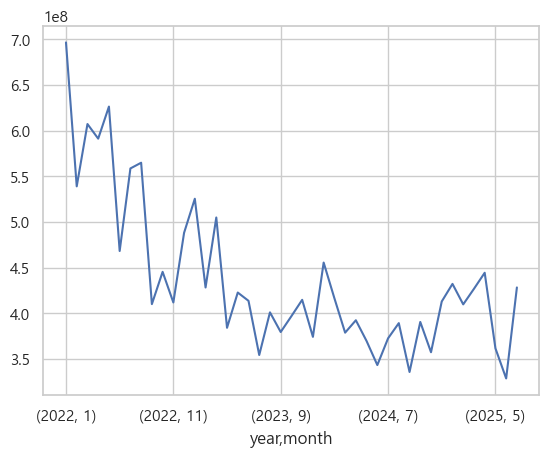

In [41]:
df.groupby(['year','month'])['value'].sum().plot(kind='line')

<Axes: xlabel='month'>

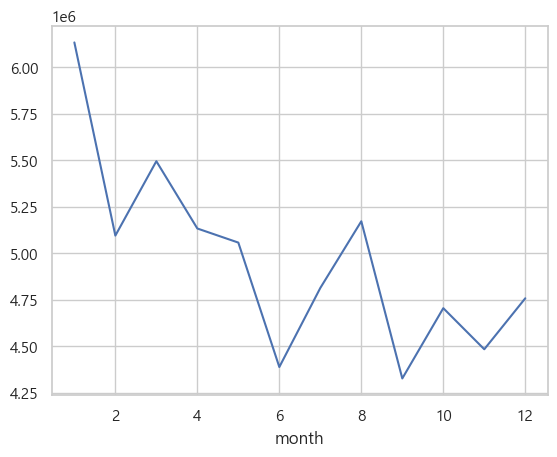

In [42]:
df.groupby('month')['value'].mean().plot(kind='line')

<Axes: xlabel='month', ylabel='value'>

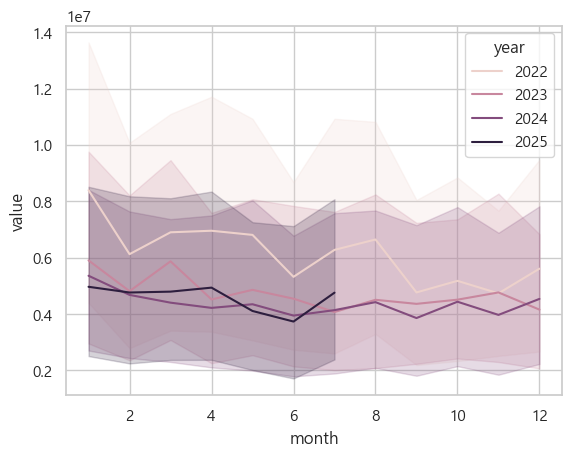

In [43]:
sns.lineplot(x='month', y='value', hue='year', data=df)

<Axes: xlabel='month', ylabel='hs4'>

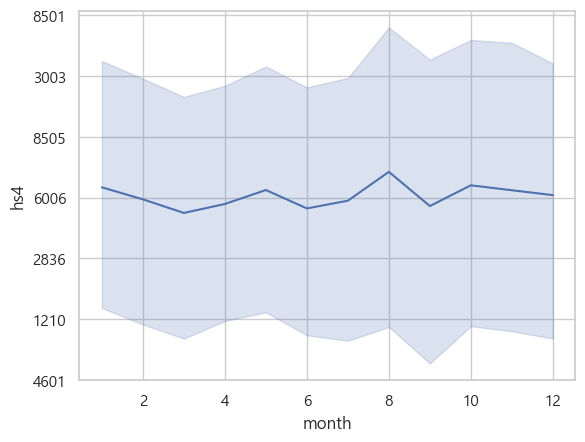

In [44]:
sns.lineplot(data=df, x='month', y='hs4')

### 3. 상관관계 및 단위 효율 분석

In [45]:
corr_df = df[['weight','quantity','value']].corr() # quantity 불필요해 보임
corr_df

,weight,quantity,value
weight,1.000000,-0.004348,0.654163
quantity,-0.004348,1.000000,-0.000240
value,0.654163,-0.000240,1.000000


<Axes: >

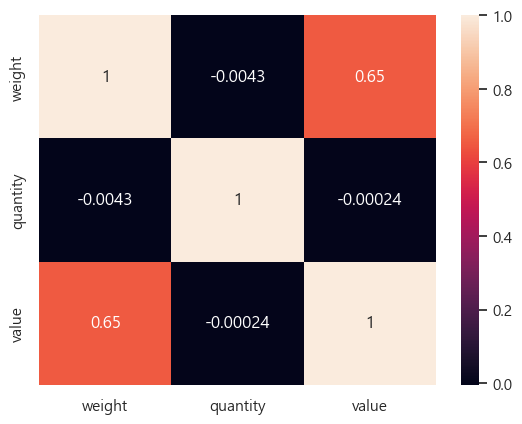

In [46]:
sns.heatmap(corr_df, annot=True)

<Axes: ylabel='count'>

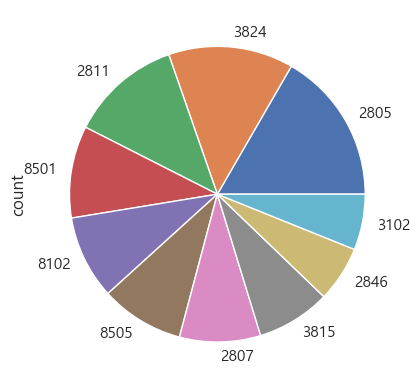

In [47]:
df['hs4'].value_counts().head(10).plot.pie() # 대분류로 다시 보기

<Axes: ylabel='count'>

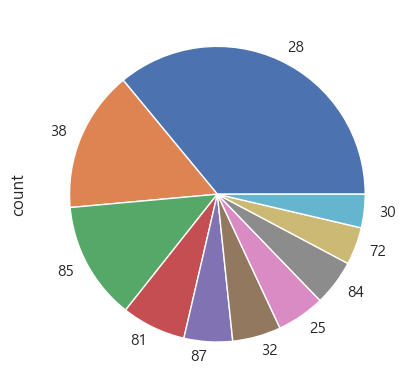

In [67]:
df['large_cat'].value_counts().head(10).plot.pie() # 대분류로 다시 보기
# 제28류 무기화학품, 귀금속ㆍ희토류(稀土類)금속ㆍ방사성원소ㆍ동위원소의 유기화합물이나 무기화합물
# 제38류 각종 화학공업 생산품
# 제85류 전기기기와 그 부분품, 녹음기ㆍ음성 재생기ㆍ텔레비전의 영상과 음성의 기록기ㆍ재생기와 이들의 부분품ㆍ부속품

<Axes: ylabel='count'>

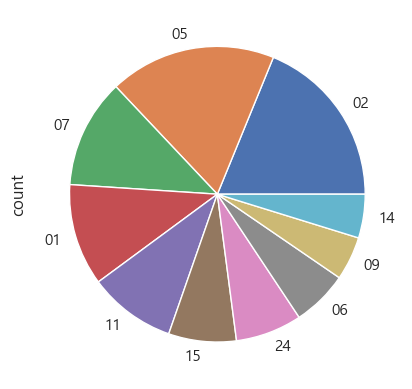

In [68]:
df['medium_cat'].value_counts().head(10).plot.pie() # 중분류는 필요한가?

In [51]:
df['unit_wq'] = df['weight'] / df['quantity']   # 무게 대비 수량 비율
df['unit_vw'] = df['value'] / df['weight']      # 무게 대비 무역량 (단가 개념)

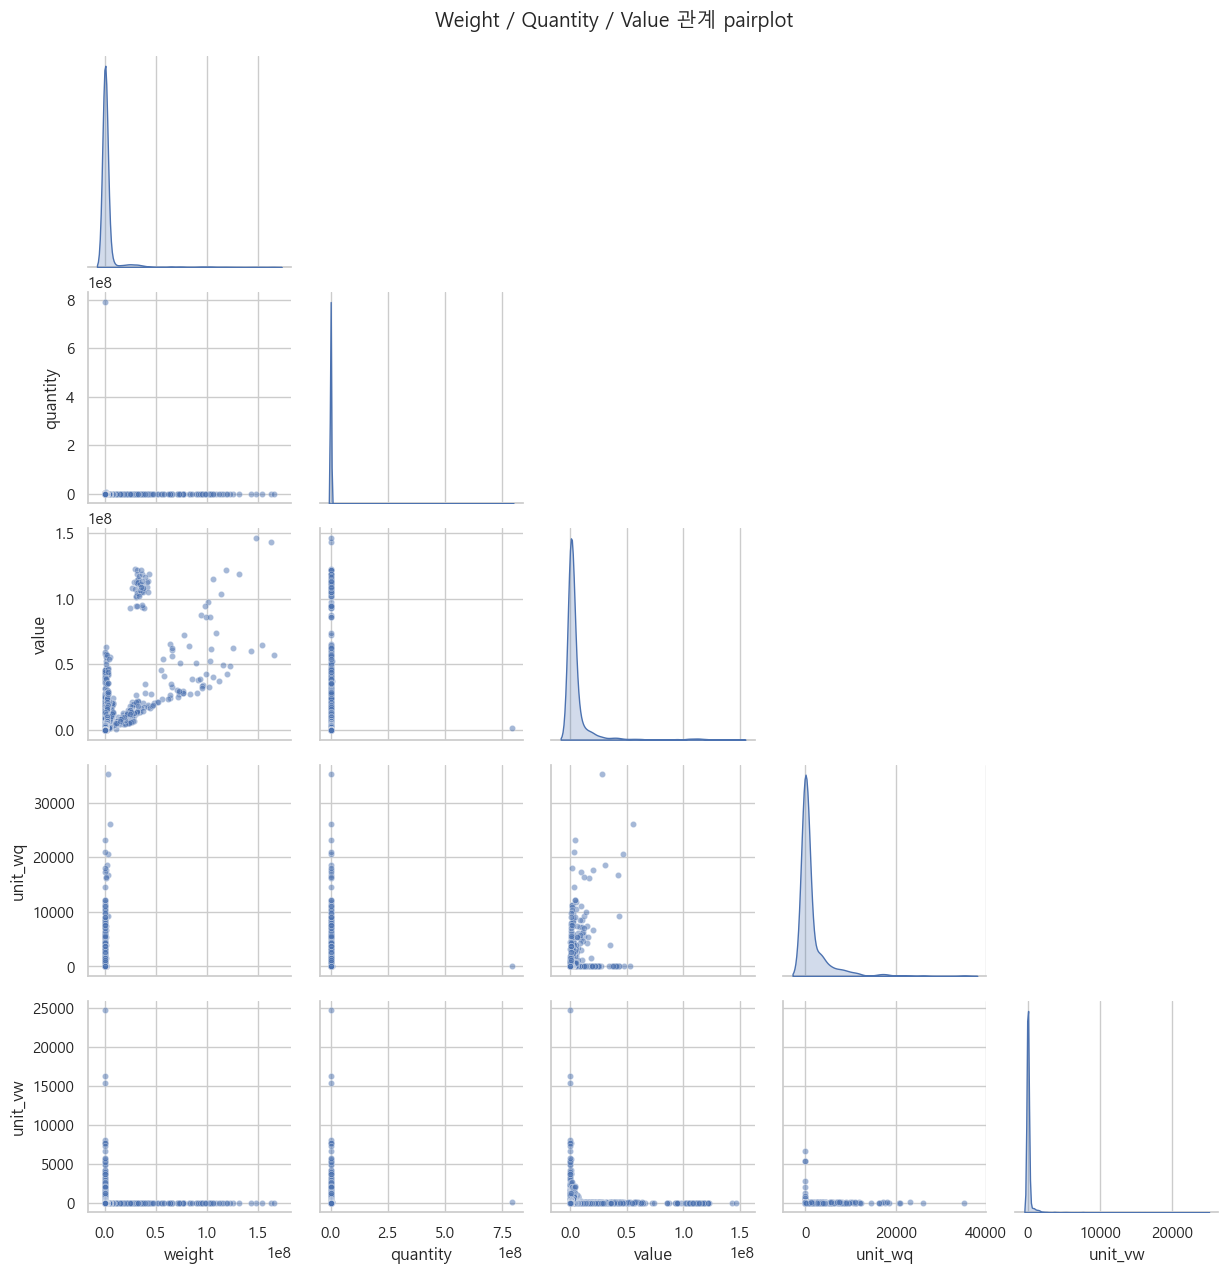

In [52]:
sns.pairplot(
    df[['weight', 'quantity', 'value', 'unit_wq', 'unit_vw']],
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha': 0.5, 's': 20}
)
plt.suptitle("Weight / Quantity / Value 관계 pairplot", y=1.02)
plt.show() # logscale 고려

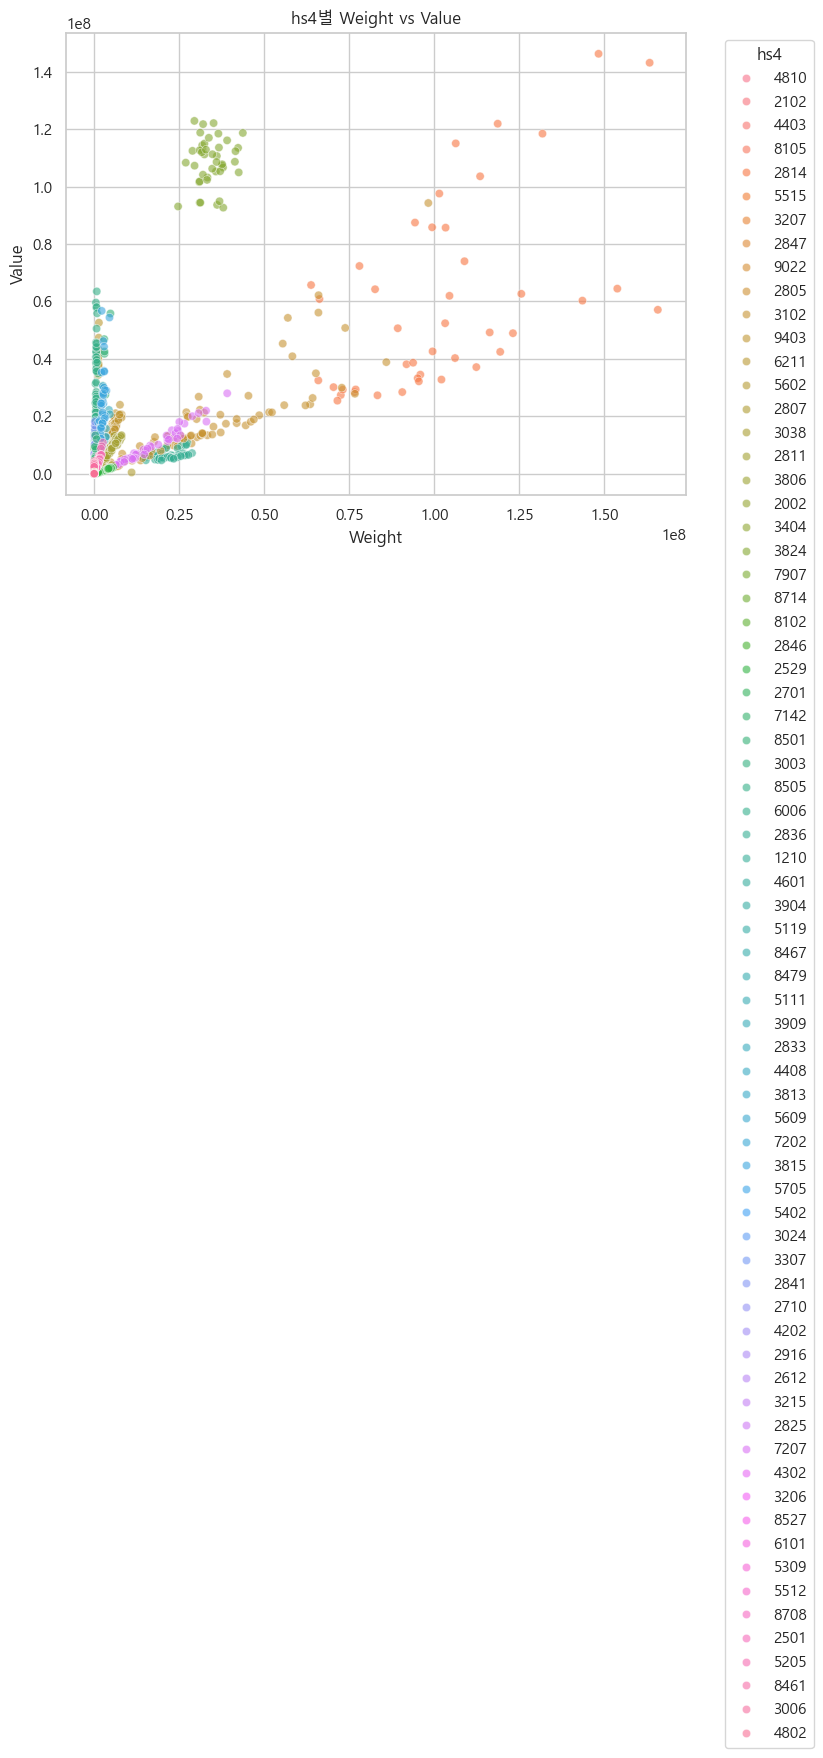

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='weight',
    y='value',
    hue='hs4',          # 또는 type
    alpha=0.6
)
plt.title('hs4별 Weight vs Value')
plt.xlabel('Weight')
plt.ylabel('Value')
plt.legend(title='hs4', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


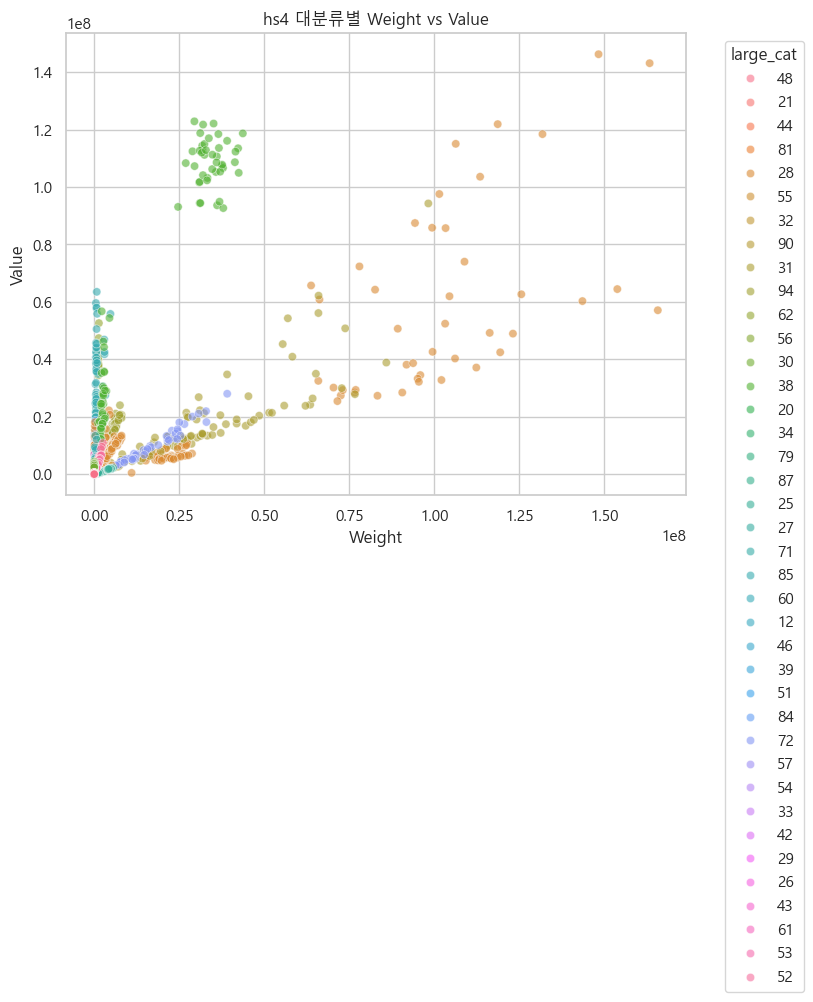

In [54]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='weight',
    y='value',
    hue='large_cat',         
    alpha=0.6
)
plt.title('hs4 대분류별 Weight vs Value')
plt.xlabel('Weight')
plt.ylabel('Value')
plt.legend(title='large_cat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


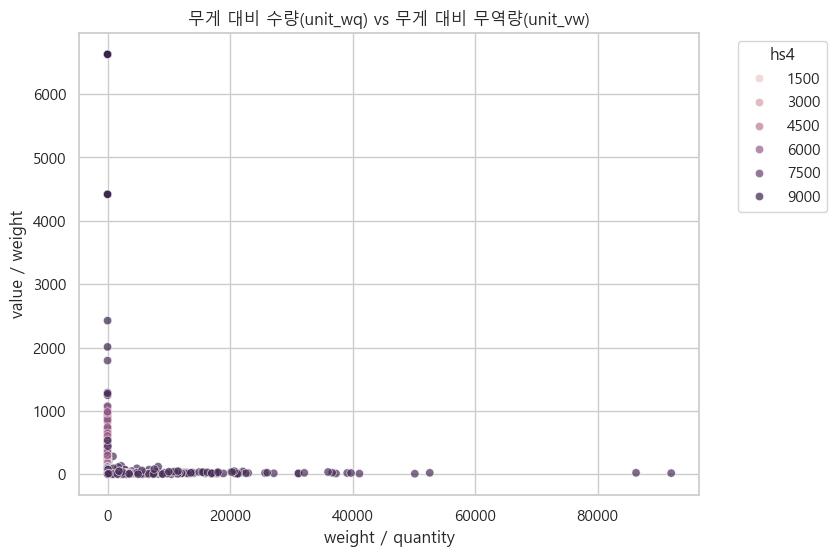

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='unit_wq',
    y='unit_vw',
    hue='hs4',
    alpha=0.7
)
plt.title('무게 대비 수량(unit_wq) vs 무게 대비 무역량(unit_vw)')
plt.xlabel('weight / quantity')
plt.ylabel('value / weight')
plt.legend(title='hs4', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show() # 9000대는 기타를 다 합쳐놓기 때문에 무게 대비 수량이 많음


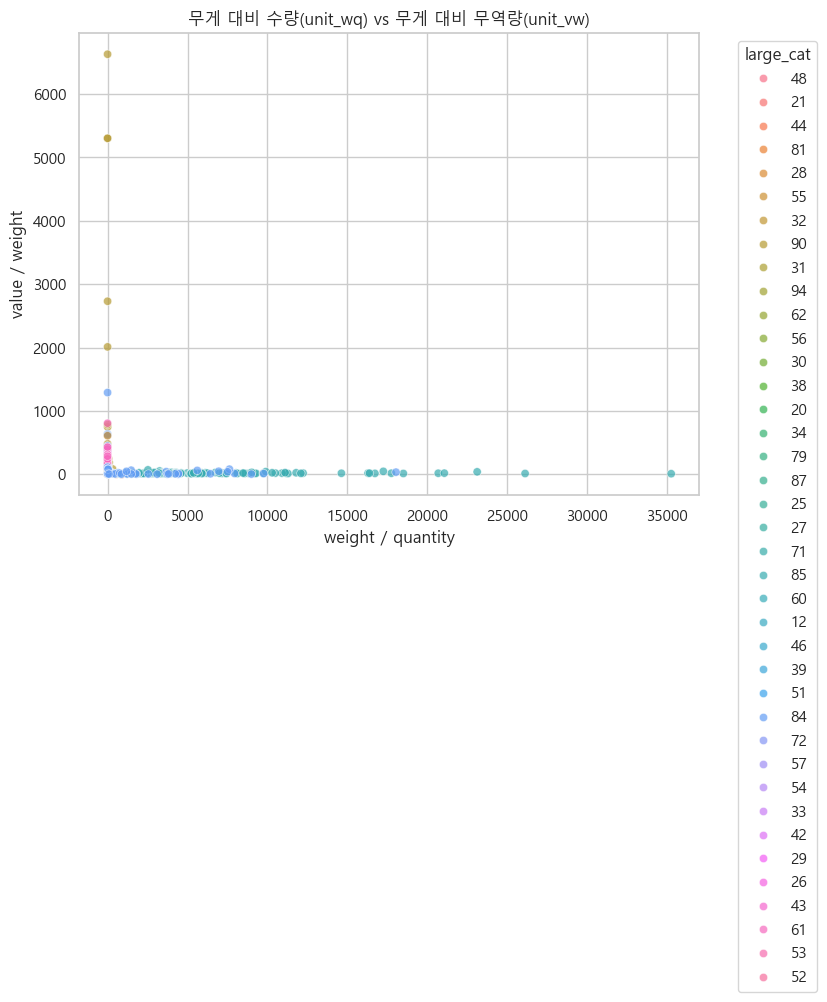

In [55]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='unit_wq',
    y='unit_vw',
    hue='large_cat',
    alpha=0.7
)
plt.title('무게 대비 수량(unit_wq) vs 무게 대비 무역량(unit_vw)')
plt.xlabel('weight / quantity')
plt.ylabel('value / weight')
plt.legend(title='large_cat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show() # 9000대는 기타를 다 합쳐놓기 때문에 무게 대비 수량이 많음


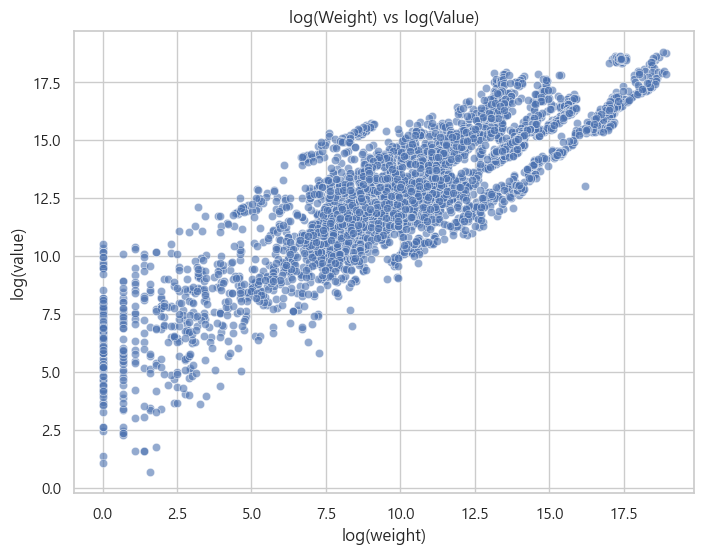

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x=np.log1p(df['weight']),
    y=np.log1p(df['value']),
    # hue='type',
    alpha=0.6
)
plt.title('log(Weight) vs log(Value)')
plt.xlabel('log(weight)')
plt.ylabel('log(value)')
# plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### 그 외 시각화

C:\Users\julia\AppData\Local\Temp\ipykernel_16704\3087859909.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


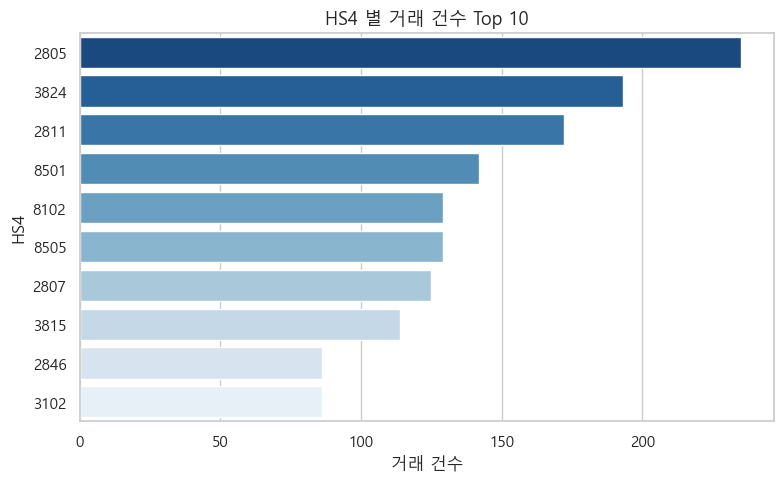

In [69]:
# HS4별 거래 건수 (상위 10개 시각화)
# --- 거래 건수 집계 ---
hs4_count = df['hs4'].value_counts().head(10).reset_index()
hs4_count.columns = ['hs4', 'count']

# --- 시각화 ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=hs4_count,
    x='count',
    y='hs4',
    palette='Blues_r'
)
plt.title('HS4 별 거래 건수 Top 10', fontsize=13)
plt.xlabel('거래 건수')
plt.ylabel('HS4')
plt.tight_layout()
plt.show() # 선 확인, 대분류를 보고 확인, 대분류 안 소분류 확인

In [70]:
# 검정 세로줄 : 에러바 (Error bar)
# 의미 : 평균값의 신뢰구간(95%) 또는 표준편차
# 길이가 긴 이유 : 그룹 내 변동성이 크거나 이상치 존재
# 제거 방법 : errorbar=None
# 완화 방법 : errorbar='sd' 또는 로그스케일 적용

C:\Users\julia\AppData\Local\Temp\ipykernel_16704\1454577569.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


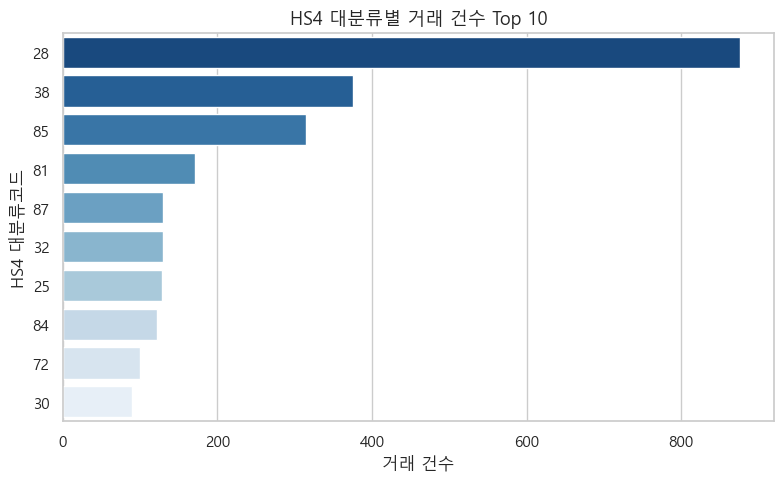

In [71]:
# HS4별 거래 건수 (상위 10개 시각화)
# --- 거래 건수 집계 ---
lc_count = df['large_cat'].value_counts().head(10).reset_index()
lc_count.columns = ['large_cat', 'count']

# --- 시각화 ---
plt.figure(figsize=(8,5))
sns.barplot(
    data=lc_count,
    x='count',
    y='large_cat',
    palette='Blues_r'
)
plt.title('HS4 대분류별 거래 건수 Top 10', fontsize=13)
plt.xlabel('거래 건수')
plt.ylabel('HS4 대분류코드')
plt.tight_layout()
plt.show() # 선 확인, 대분류를 보고 확인, 대분류 안 소분류 확인

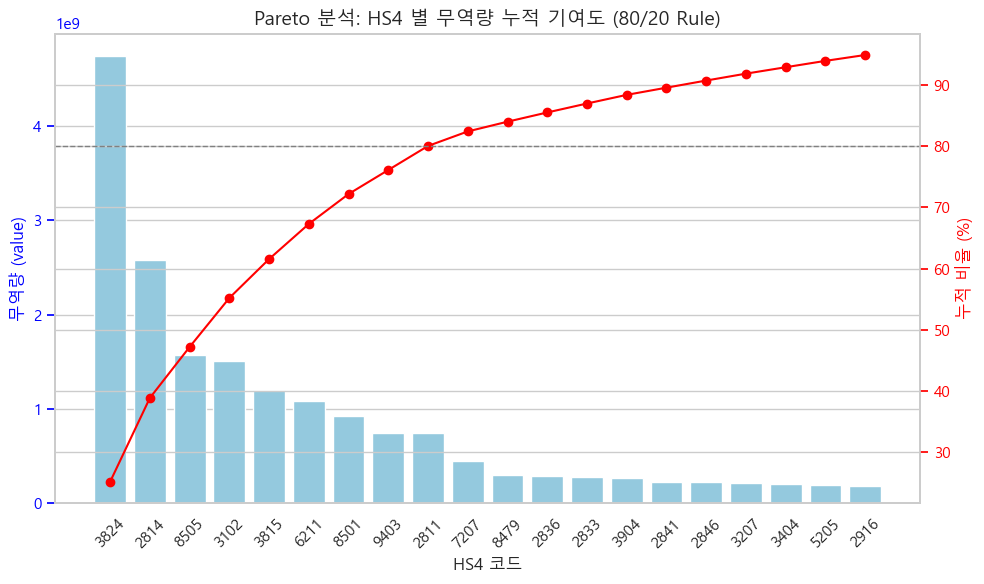

In [73]:
# HS4별 무역량 기여도 (Pareto 80/20 Rule Plot)
# --- HS4별 총 무역량(value) 계산 ---
hs4_value = df.groupby('hs4')['value'].sum().sort_values(ascending=False).reset_index()

# --- 누적 비율 계산 ---
hs4_value['cum_sum'] = hs4_value['value'].cumsum()
hs4_value['cum_perc'] = 100 * hs4_value['cum_sum'] / hs4_value['value'].sum()

# --- 시각화 ---
fig, ax1 = plt.subplots(figsize=(10,6))

# 막대: HS4별 무역량
sns.barplot(data=hs4_value.head(20), x='hs4', y='value', color='skyblue', ax=ax1)
ax1.set_xlabel('HS4 코드')
ax1.set_ylabel('무역량 (value)', color='blue')
ax1.tick_params('y', colors='blue')
plt.xticks(rotation=45)

# 라인: 누적 비율
ax2 = ax1.twinx()
ax2.plot(hs4_value['hs4'].head(20), hs4_value['cum_perc'].head(20), color='red', marker='o')
ax2.set_ylabel('누적 비율 (%)', color='red')
ax2.tick_params('y', colors='red')
ax2.axhline(80, color='gray', linestyle='--', linewidth=1)  # 80% 기준선

plt.title('Pareto 분석: HS4 별 무역량 누적 기여도 (80/20 Rule)', fontsize=14)
plt.tight_layout()
plt.show()


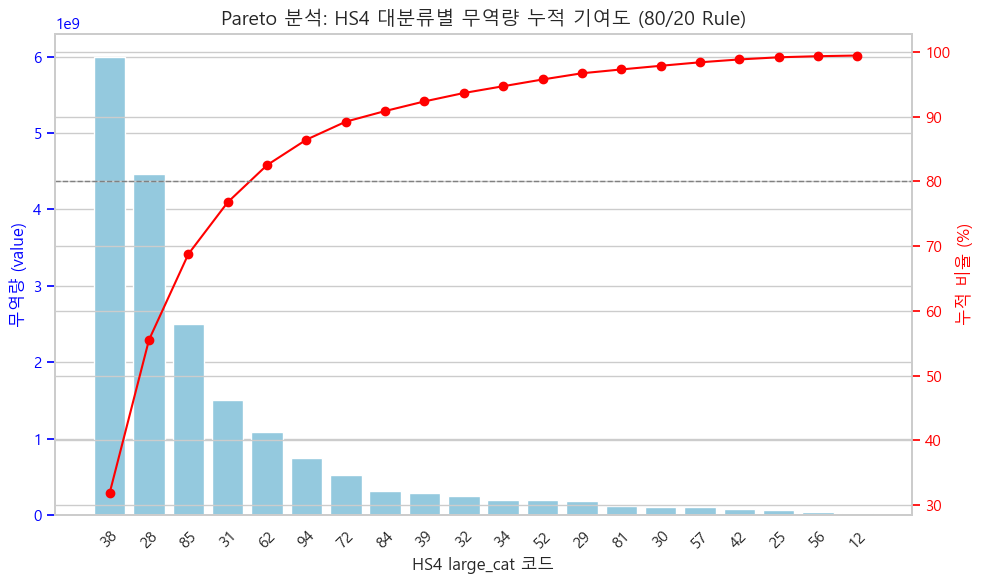

In [74]:
# large_cat별 무역량 기여도 (Pareto 80/20 Rule Plot)
# --- large_cat별 총 무역량(value) 계산 ---
lc_value = df.groupby('large_cat')['value'].sum().sort_values(ascending=False).reset_index()

# --- 누적 비율 계산 ---
lc_value['cum_sum'] = lc_value['value'].cumsum()
lc_value['cum_perc'] = 100 * lc_value['cum_sum'] / lc_value['value'].sum()

# --- 시각화 ---
fig, ax1 = plt.subplots(figsize=(10,6))

# 막대: HS4별 무역량
sns.barplot(data=lc_value.head(20), x='large_cat', y='value', color='skyblue', ax=ax1)
ax1.set_xlabel('HS4 large_cat 코드')
ax1.set_ylabel('무역량 (value)', color='blue')
ax1.tick_params('y', colors='blue')
plt.xticks(rotation=45)

# 라인: 누적 비율
ax2 = ax1.twinx()
ax2.plot(lc_value['large_cat'].head(20), lc_value['cum_perc'].head(20), color='red', marker='o')
ax2.set_ylabel('누적 비율 (%)', color='red')
ax2.tick_params('y', colors='red')
ax2.axhline(80, color='gray', linestyle='--', linewidth=1)  # 80% 기준선

plt.title('Pareto 분석: HS4 대분류별 무역량 누적 기여도 (80/20 Rule)', fontsize=14)
plt.tight_layout()
plt.show()


In [77]:
# “80%를 차지하는 HS4 코드”만 추출하고 싶을 때
top_80 = hs4_value[hs4_value['cum_perc'] <= 80]
print(f"전체 무역량의 80%를 차지하는 HS4 코드 개수: {len(top_80)}개")
print(top_80) # 대분류 나눠서 산업군 확인하기!!!! -> 소분류도 확인해보기
# 80%를 차지하는 산업군은 다른 산업군에도 영향을 미칠 것으로 사료됨.

전체 무역량의 80%를 차지하는 HS4 코드 개수: 8개
    hs4         value       cum_sum   cum_perc
0  3824  4.746594e+09  4.746594e+09  25.182748
1  2814  2.579887e+09  7.326481e+09  38.870171
2  8505  1.569531e+09  8.896012e+09  47.197216
3  3102  1.509013e+09  1.040502e+10  55.203187
4  3815  1.198069e+09  1.160309e+10  61.559463
5  6211  1.081998e+09  1.268509e+10  67.299932
6  8501  9.209009e+08  1.360599e+10  72.185712
7  9403  7.404158e+08  1.434641e+10  76.113940


In [78]:
# “80%를 차지하는 HS4 대분류 코드”만 추출하고 싶을 때
top_80 = lc_value[lc_value['cum_perc'] <= 80]
print(f"전체 무역량의 80%를 차지하는 대분류코드 개수: {len(top_80)}개")
print(top_80) # 대분류 나눠서 산업군 확인하기!!!! -> 소분류도 확인해보기
# 80%를 차지하는 산업군은 다른 산업군에도 영향을 미칠 것으로 사료됨.

전체 무역량의 80%를 차지하는 대분류코드 개수: 4개
  large_cat         value       cum_sum   cum_perc
0        38  6.002055e+09  6.002055e+09  31.843516
1        28  4.461838e+09  1.046389e+10  55.515507
2        85  2.496308e+09  1.296020e+10  68.759509
3        31  1.509013e+09  1.446921e+10  76.765481


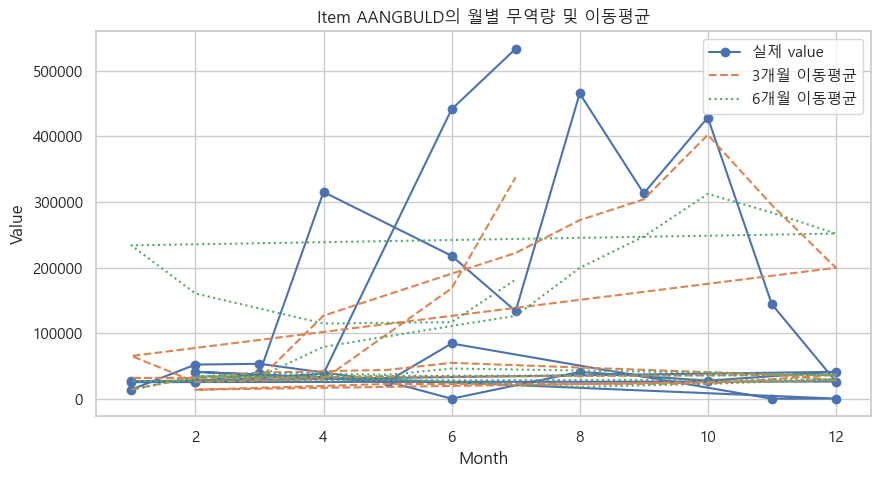

In [61]:
# --- 연월을 기준으로 정렬 ---
df = df.sort_values(['item_id', 'year', 'month'])

# --- 그룹별 rolling mean 계산 ---
# 무역량(value)의 3개월, 6개월 이동평균
df['value_rm3'] = df.groupby('item_id')['value'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['value_rm6'] = df.groupby('item_id')['value'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())

# --- 시각화 (예시: 특정 item_id의 추세) ---
sample_item = df['item_id'].iloc[0]  # 임의 선택
sample_df = df[df['item_id'] == sample_item]

plt.figure(figsize=(10,5))
plt.plot(sample_df['month'], sample_df['value'], label='실제 value', marker='o')
plt.plot(sample_df['month'], sample_df['value_rm3'], label='3개월 이동평균', linestyle='--')
plt.plot(sample_df['month'], sample_df['value_rm6'], label='6개월 이동평균', linestyle=':') # 이동평균 3개월, 6개월 + 1년~
plt.title(f'Item {sample_item}의 월별 무역량 및 이동평균')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# --- item별 평균 지표 계산 ---
item_stats = df.groupby('item_id').agg({
    'weight': 'mean',
    'quantity': 'mean',
    'value': 'mean'
}).reset_index()

item_stats.rename(columns={
    'weight': 'weight_per_item',
    'quantity': 'quantity_per_item',
    'value': 'value_per_item'
}, inplace=True)

# --- 상대적 효율 지표 ---
item_stats['value_per_kg'] = item_stats['value_per_item'] / item_stats['weight_per_item']  # 무게당 금액
item_stats['value_per_quantity'] = item_stats['value_per_item'] / item_stats['quantity_per_item']  # 수량당 금액

# --- 정렬 및 확인 ---
item_stats = item_stats.sort_values('value_per_kg', ascending=False)
print(item_stats.head())


     item_id  weight_per_item  quantity_per_item  value_per_item  \
30  GMBFCMIU         0.000000                0.0    1.130000e+03   
38  JSLXRQOK         3.731707                0.0    1.589120e+04   
16  DJBLNPNC         0.962963                0.0    3.159000e+03   
89  WQMVCOEM       118.857143                0.0    1.503803e+05   
97  ZGJXVMNI      1948.581395                0.0    2.256273e+06   

    value_per_kg  value_per_quantity  
30           inf                 inf  
38   4258.424837                 inf  
16   3280.500000                 inf  
89   1265.218950                 inf  
97   1157.905513                 inf  


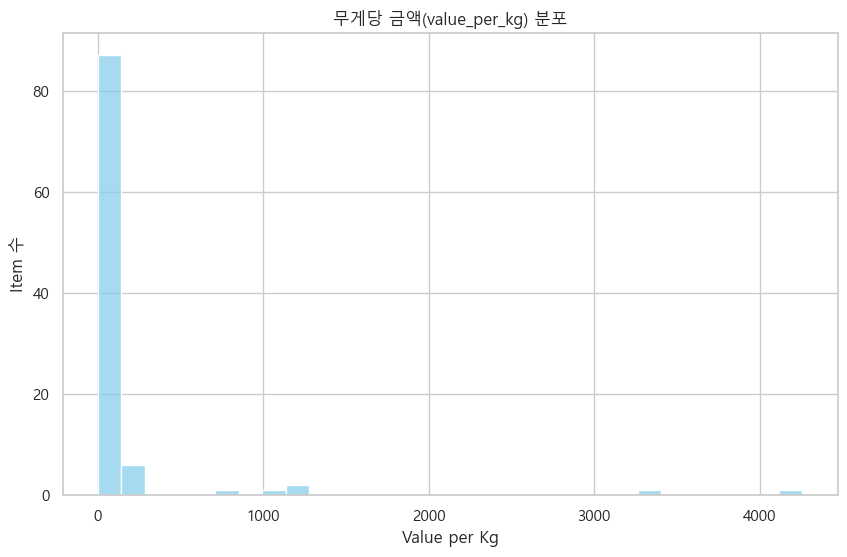

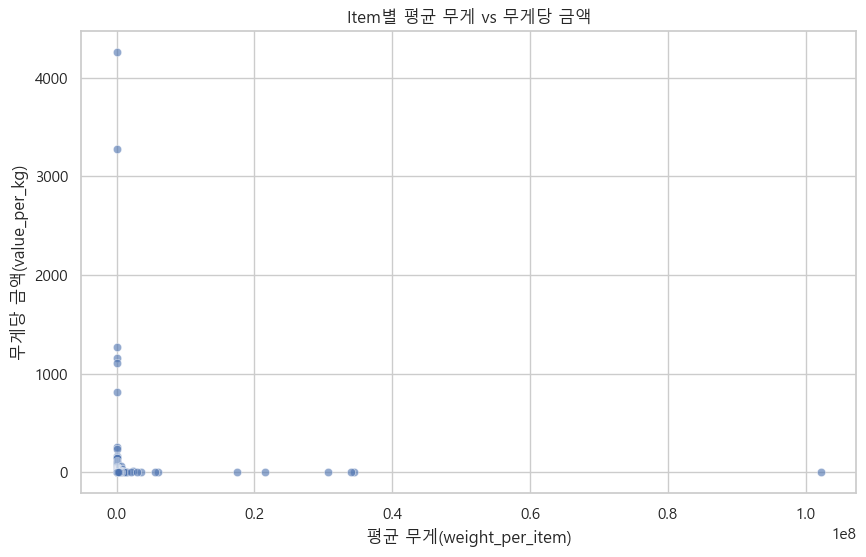

In [63]:
plt.figure(figsize=(10,6))
sns.histplot(item_stats['value_per_kg'], bins=30, color='skyblue')
plt.title('무게당 금액(value_per_kg) 분포')
plt.xlabel('Value per Kg')
plt.ylabel('Item 수')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=item_stats,
    x='weight_per_item',
    y='value_per_kg',
    alpha=0.6
)
plt.title('Item별 평균 무게 vs 무게당 금액')
plt.xlabel('평균 무게(weight_per_item)')
plt.ylabel('무게당 금액(value_per_kg)')
plt.show()


In [64]:
# 전체 item별 구조지표
trade_summary = item_stats[['item_id', 'weight_per_item', 'quantity_per_item', 'value_per_kg', 'value_per_quantity']]

# 효율 상위/하위 아이템 확인
top_items = trade_summary.sort_values('value_per_kg', ascending=False).head(10)
bottom_items = trade_summary.sort_values('value_per_kg', ascending=True).head(10)

print("💎 고부가가치 Top 10")
print(top_items)
print("\n📦 저부가가치 Bottom 10")
print(bottom_items) # hs4 추가해서 어떤건지 확인해보기


💎 고부가가치 Top 10
     item_id  weight_per_item  quantity_per_item  value_per_kg  \
30  GMBFCMIU         0.000000           0.000000           inf   
38  JSLXRQOK         3.731707           0.000000   4258.424837   
16  DJBLNPNC         0.962963           0.000000   3280.500000   
89  WQMVCOEM       118.857143           0.000000   1265.218950   
97  ZGJXVMNI      1948.581395           0.000000   1157.905513   
75  SUOYXCHP        38.783784           0.000000   1110.344948   
6   BEZYMBBT      6055.418605           0.000000    815.694669   
8   BLANHGYY        73.103448           4.517241    255.325000   
81  UXSPKBJR      3087.023256           0.000000    231.188983   
51  NAQIHUKZ        46.115385           0.000000    168.897415   

    value_per_quantity  
30                 inf  
38                 inf  
16                 inf  
89                 inf  
97                 inf  
75                 inf  
6                  inf  
8          4131.977099  
81                 inf  
51      

C:\Users\julia\AppData\Local\Temp\ipykernel_16704\1827034508.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hs4_eff.sort_values('value_per_kg', ascending=False).head(10),


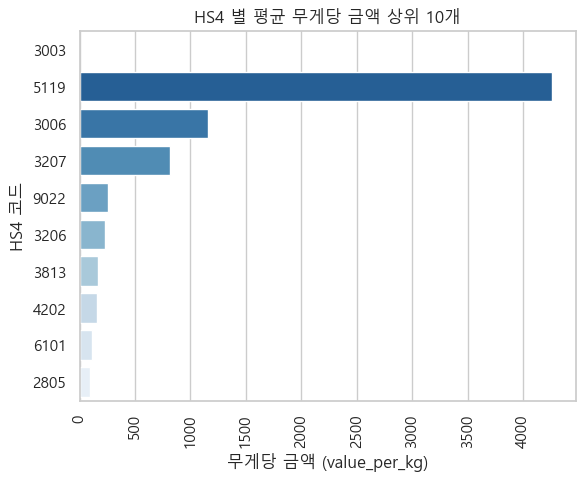

In [82]:
hs4_eff = df.groupby('hs4').agg({
    'weight': 'mean',
    'quantity': 'mean',
    'value': 'mean'
}).reset_index()

hs4_eff['value_per_kg'] = hs4_eff['value'] / hs4_eff['weight']

sns.barplot(data=hs4_eff.sort_values('value_per_kg', ascending=False).head(10),
            x='value_per_kg', y='hs4', palette='Blues_r')
plt.title('HS4 별 평균 무게당 금액 상위 10개')
plt.xlabel('무게당 금액 (value_per_kg)')
plt.xticks(rotation=90)
plt.ylabel('HS4 코드')
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_16704\1645866665.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lc_eff.sort_values('value_per_kg', ascending=False).head(10),


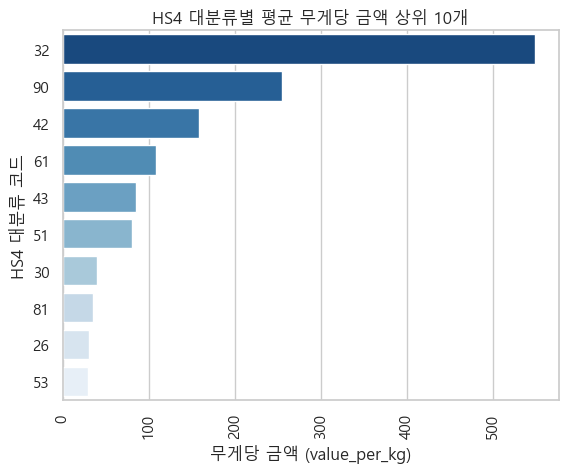

In [83]:
lc_eff = df.groupby('large_cat').agg({
    'weight': 'mean',
    'quantity': 'mean',
    'value': 'mean'
}).reset_index()

lc_eff['value_per_kg'] = lc_eff['value'] / lc_eff['weight']

sns.barplot(data=lc_eff.sort_values('value_per_kg', ascending=False).head(10),
            x='value_per_kg', y='large_cat', palette='Blues_r')
plt.title('HS4 대분류별 평균 무게당 금액 상위 10개')
plt.xlabel('무게당 금액 (value_per_kg)')
plt.xticks(rotation=90)
plt.ylabel('HS4 대분류 코드')
plt.show()
# 제32류 유연용ㆍ염색용 추출물(extract), 탄닌과 이들의 유도체, 염료ㆍ안료와 그 밖의 착색제, 페인트ㆍ바니시(varnish), 퍼티(putty)와 그 밖의 매스틱(mastic), 잉크
# 제90류 광학기기ㆍ사진용 기기ㆍ영화용 기기ㆍ측정기기ㆍ검사기기ㆍ정밀기기ㆍ의료용 기기, 이들의 부분품과 부속품